In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
DATA_DIR = pathlib.Path("data")

# Outline

The model is loosely based on [Enhancing the Locality and Breaking the Memory Bottleneck of Transformer on Time Series Forecasting
](https://arxiv.org/abs/1907.00235). We do not implement "learnable" positional encoding, allowing convolutions to do the job. Outputs are distribution parameters, similar to DeepAR.

# Loading data

In [5]:
df = pd.read_csv("data/AEP_hourly.csv.zip", parse_dates=["Datetime"], index_col="Datetime")

In [6]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


## Fix timestamps

In [7]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [8]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [9]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [10]:
df[~df.index.duplicated(keep='first')]

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [11]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [12]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

### Missing values

In [13]:
dfi.isnull().mean()

AEP_MW    0.000223
dtype: float64

In [14]:
dfi.ffill(inplace=True)

# Various model blocks

In [15]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

# Causal convolution

In [16]:
class CausalConv1D(pl.LightningModule):
    """Causal convolution for transformer model."""
   
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 padding_mode: str = 'zeros'):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding_mode = padding_mode
        self.padding_requirement = kernel_size - 1

        self.layer = nn.Conv1d(self.in_channels,
                               self.out_channels,
                               self.kernel_size,
                               padding=self.padding_requirement,
                               padding_mode=self.padding_mode)

    def forward(self, x):
        x_out = self.layer(x)
        return x_out[:, :, :-self.padding_requirement]

In [17]:
test_input = torch.Tensor(np.random.randn(1, 4, 100))

causal_conv = CausalConv1D(4, 8, 3)

In [18]:
test_output = causal_conv(test_input)

In [19]:
test_output.shape

torch.Size([1, 8, 100])

In [20]:
causal_conv.layer.weight.shape

torch.Size([8, 4, 3])

In [21]:
FILTER_N = 1

torch.sum(test_input[0, :, -3:].view(4, 3) * causal_conv.layer.weight[FILTER_N]) + causal_conv.layer.bias[FILTER_N]

tensor(-0.4234, grad_fn=<AddBackward0>)

In [22]:
test_output[:, FILTER_N, -1]

tensor([-0.4234], grad_fn=<SelectBackward>)

# Positional encoding

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 dim: int,
                 max_len: int = 168,
                 dropout: float = 0.1):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(dim, max_len)
        position = torch.arange(0, max_len, dtype=torch.float)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim)).unsqueeze(1)
        pe[0::2, :] = torch.sin(position * div_term)
        pe[1::2, :] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :, :x.size(-1)]
        return self.dropout(x)

In [24]:
pos_enc = PositionalEncoding(8, 100)

In [25]:
pos_enc.pe.shape

torch.Size([1, 8, 100])

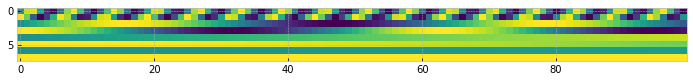

In [26]:
plt.imshow(pos_enc.pe.numpy()[0])

In [27]:
pos_enc(test_output).shape

torch.Size([1, 8, 100])

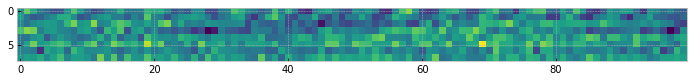

In [28]:
plt.imshow(pos_enc(test_output).detach().numpy()[0])

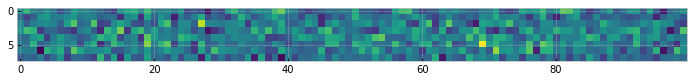

In [29]:
plt.imshow(test_output.detach().numpy()[0])

# `TransformerEncoder` layer

In [30]:
tenc_layer = nn.TransformerEncoderLayer(8, 8, 16)
test_enc = tenc_layer(pos_enc(test_output).permute(2, 0, 1))

In [31]:
test_enc.shape

torch.Size([100, 1, 8])

In [32]:
tenc_layer.self_attn

MultiheadAttention(
  (out_proj): _LinearWithBias(in_features=8, out_features=8, bias=True)
)

# Dataset and DataModule

In [33]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values).unsqueeze(0),
                torch.Tensor(fct_data[self.col].values).unsqueeze(0))

In [34]:
ds = ElectricityDataset(dfi, 10)

In [35]:
start_ts = ds.sample_idx[4]

In [36]:
dfi[start_ts:].head()

,AEP_MW
2010-01-12 02:00:00,17296.0
2010-01-12 03:00:00,17217.0
2010-01-12 04:00:00,17105.0
2010-01-12 05:00:00,17456.0
2010-01-12 06:00:00,18295.0


In [37]:
dfi[start_ts+pd.Timedelta(days=7):].head()

,AEP_MW
2010-01-19 02:00:00,15454.0
2010-01-19 03:00:00,15237.0
2010-01-19 04:00:00,15130.0
2010-01-19 05:00:00,15315.0
2010-01-19 06:00:00,16079.0


In [38]:
ds[4]

(tensor([[17296., 17217., 17105., 17456., 18295., 19818., 20823., 20843., 20626.,
          20366., 20062., 19818., 19616., 19344., 19203., 19495., 20283., 20917.,
          20822., 20706., 20321., 19555., 18752., 18076., 17988., 17988., 18123.,
          18565., 19495., 21204., 22279., 21999., 21336., 20509., 19541., 18888.,
          18429., 17910., 17628., 17956., 18937., 19984., 20190., 20088., 19819.,
          19077., 18288., 17766., 17521., 17451., 17467., 17864., 18832., 20420.,
          21306., 21054., 20408., 19540., 18680., 18019., 17340., 16988., 16839.,
          17091., 17997., 18895., 18887., 18865., 18438., 17764., 16843., 16382.,
          16090., 15975., 15966., 16338., 17119., 18492., 19417., 19255., 18822.,
          18533., 18016., 17580., 17232., 16812., 16636., 16708., 17356., 17744.,
          17601., 17425., 17168., 16541., 15823., 15233., 14979., 14851., 14924.,
          15003., 15216., 15864., 16547., 16911., 17123., 17051., 16548., 16112.,
          15658.

In [39]:
class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

# Model

In [144]:
torch.device("cuda")

device(type='cuda')

In [200]:
class ElectricityLoadTransformer(pl.LightningModule):
    """ransformer model for electricity load forecasting."""
   
    def __init__(self,
                 hist_len: int = 168,
                 fct_len: int = 24,
                 kernels: int = 8,
                 kernel_size: int = 5,
                 pos_dropout: float = 0.1,
                 tr_dropout: float = 0.1,
                 heads: int = 8,
                 dim_feedforward: int = 32,
                 lr: float = 1e-3):
        super().__init__()

        self.hist_len = hist_len
        self.fct_len = fct_len
        self.kernels = kernels
        self.kernel_size = kernel_size
        self.pos_dropout = pos_dropout
        self.tr_dropout = tr_dropout
        self.heads = heads
        self.dim_feedforward = dim_feedforward
        self.lr = lr
        
        self.conv_encoder = CausalConv1D(1, self.kernels, self.kernel_size)
        self.pos_encoder = PositionalEncoding(self.kernels, self.hist_len+self.fct_len, self.pos_dropout)
        self.transformer_block = nn.TransformerEncoderLayer(d_model=self.kernels,
                                                            nhead=self.heads,
                                                            dim_feedforward=self.dim_feedforward,
                                                            dropout=self.tr_dropout)

        self.mu = nn.Linear(in_features=self.kernels, out_features=1)
        self.sigma_raw = nn.Linear(in_features=self.kernels, out_features=1)
        self.sigma = nn.Softplus()

        # Mask
        mask = torch.triu(torch.ones(self.hist_len + self.fct_len,
                                     self.hist_len + self.fct_len), diagonal=1) == 1
        self.register_buffer("mask", mask)
        

    def forward(self, x):
        
        conv_enc = self.conv_encoder(x)
        pos_enc = self.pos_encoder(conv_enc)
        local_mask = self.mask[:pos_enc.size(-1), :pos_enc.size(-1)]
        
        transformed = self.transformer_block(pos_enc.permute(2, 0, 1), src_mask=local_mask)

        mu = self.mu(transformed)
        sigma = self.sigma(self.sigma_raw(transformed))
        return transformed, mu, sigma

    def step(self, batch, batch_idx, tag="train"):
        combined_input = torch.cat(batch, dim=-1)

        # Pushing through the network
        out, mu, sigma = self(combined_input[:, :, :-1])
        loss = self.loss(mu, sigma, combined_input[:, :, 1:].permute(2, 0, 1))
        self.log(f'{tag}_logprob', loss, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, tag="val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def sample(self, x, samples):
        # Handle single stream or multiple streams
        # Note the differences in indexing compared to DeepAR
        x = x.view(-1, 1, self.hist_len)

        # Initial pass - `mu(T+1)` and `sigma(T+1)` are ready
        out, mu, sigma = self(x)

        # Sample from the distribution
        gaussian = torch.distributions.normal.Normal(mu[-1, :, -1], sigma[-1, :, -1])
        initial_sample = gaussian.sample((samples,))

        all_samples = []

        # Iterating over samples
        for sample in range(samples):
            current_sample = initial_sample[sample].view(-1, 1, 1)
            step_in = torch.cat([x, current_sample], dim=-1)
            
            # Iterating over time steps
            for step in range(self.fct_len - 1):
                step_out, mu, sigma = self(step_in[:, :, step+1:])

                # Sampling the next step value
                gaussian = torch.distributions.normal.Normal(mu[-1, :, -1], sigma[-1, :, -1])
                current_sample = gaussian.sample((1,)).view(-1, 1, 1)

                # Input tensor for the next step
                step_in = torch.cat([step_in, current_sample], dim=-1)
            all_samples.append(step_in[:, :, -self.fct_len:].unsqueeze(-1))
        return torch.cat(all_samples, dim=-1)

    def loss(self, mu, sigma, y):
        # Distribution with generated `mu` and `sigma`
        gaussian = torch.distributions.normal.Normal(mu, sigma)

        # Log-likelihood
        L = gaussian.log_prob(y)

        return -torch.mean(L)

In [201]:
model = ElectricityLoadTransformer()
model

ElectricityLoadTransformer(
  (conv_encoder): CausalConv1D(
    (layer): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(4,))
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_block): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=32, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=32, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (mu): Linear(in_features=8, out_features=1, bias=True)
  (sigma_raw): Linear(in_features=8, out_features=1, bias=True)
  (sigma): Softplus(beta=1, threshold=20)
)

In [202]:
model_input = torch.Tensor(np.random.randn(2, 1, 168))
model_output, mu, sigma = model(model_input)

In [203]:
model_output.shape, mu.shape, sigma.shape

(torch.Size([168, 2, 8]), torch.Size([168, 2, 1]), torch.Size([168, 2, 1]))

In [204]:
samples = model.sample(model_input, 3)

In [205]:
samples.shape

torch.Size([2, 1, 24, 3])

# Scaling

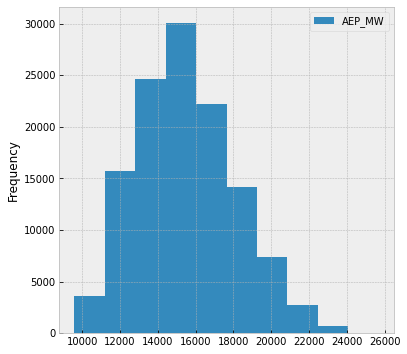

In [46]:
plt.figure(figsize=(6,6))
dfi.plot(kind="hist", ax=plt.gca())

In [47]:
LIMH, LIML =26e3, 9e3

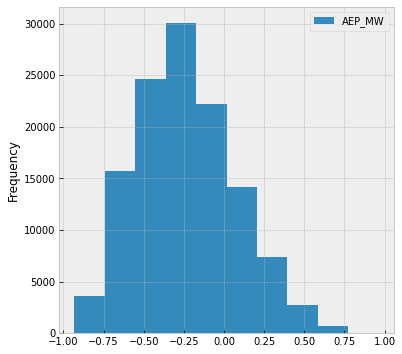

In [48]:
plt.figure(figsize=(6,6))
((2 * dfi - LIML - LIMH) / (LIMH - LIML)).plot(kind="hist", ax=plt.gca())

In [49]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)

In [206]:
ds = ElectricityDataModule(dfs, batch_size=32)
model = ElectricityLoadTransformer(kernels=64, heads=8, dim_feedforward=512)
trainer = pl.Trainer(max_epochs=10, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(model, ds)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                    | Params
--------------------------------------------------------------
0 | conv_encoder      | CausalConv1D            | 384   
1 | pos_encoder       | PositionalEncoding      | 0     
2 | transformer_block | TransformerEncoderLayer | 83.0 K
3 | mu                | Linear                  | 65    
4 | sigma_raw         | Linear                  | 65    
5 | sigma             | Softplus                | 0     
--------------------------------------------------------------
83.5 K    Trainable params
0         Non-trainable params
83.5 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

# Testing the model

In [207]:
ds.setup("test")
dl = ds.test_dataloader()

hist, fct = next(iter(dl))

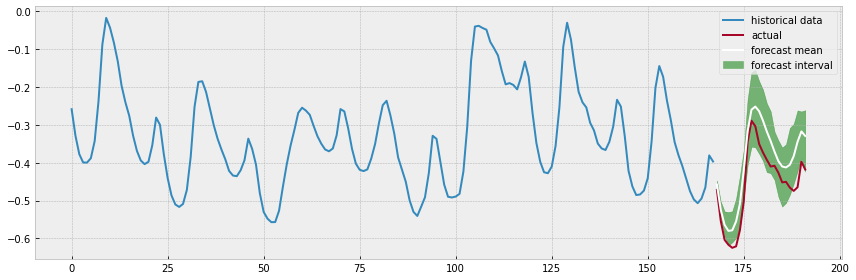

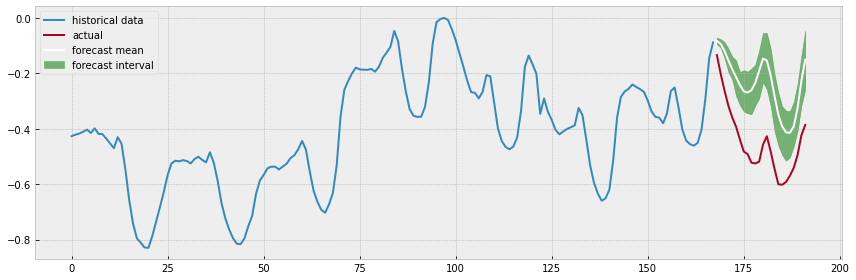

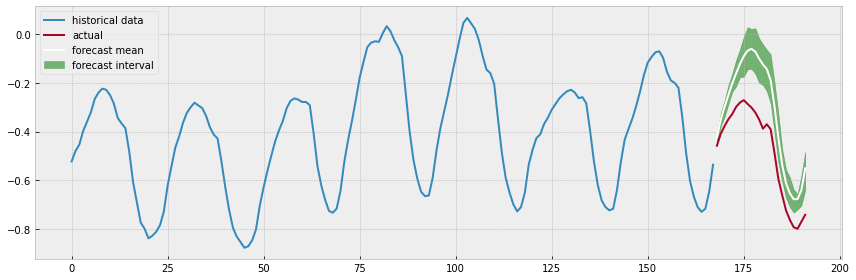

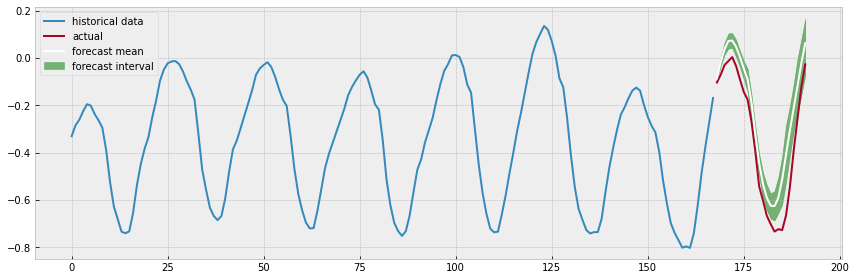

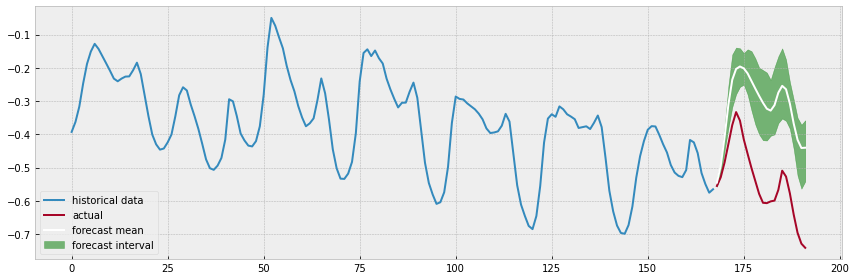

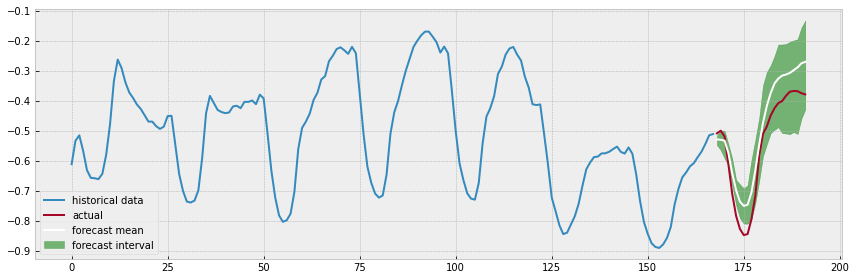

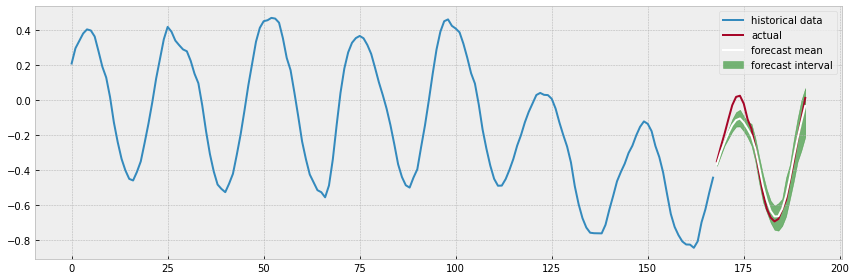

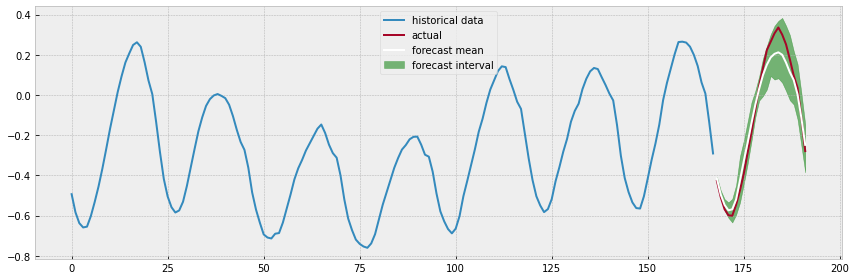

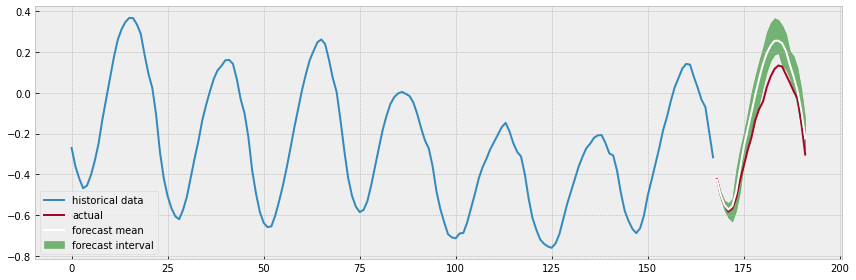

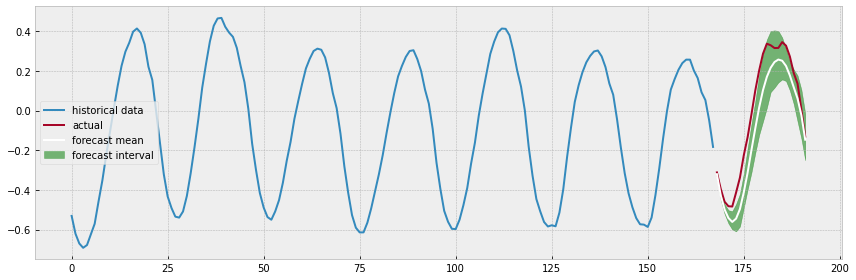

In [208]:
for stream in range(10):
    sampled = model.sample(hist[[stream]], 32)
    sampled_mean = sampled.mean(dim=-1)
    sampled_qhigh = sampled.quantile(0.75, dim=-1)
    sampled_qlow = sampled.quantile(0.25, dim=-1)

    plt.figure(figsize=(12,4))

    plt.plot(hist[stream][0], label="historical data")
    plt.plot(np.arange(168, 192, 1), fct[stream].detach().numpy()[0], label="actual")
    plt.plot(np.arange(168, 192, 1), sampled_mean.detach().numpy()[0, 0],
             color="white",
             label="forecast mean")
    plt.fill_between(np.arange(168, 192, 1),
                     sampled_qlow.detach().numpy()[0, 0],
                     sampled_qhigh.detach().numpy()[0, 0],
                     label="forecast interval", color="forestgreen", alpha=0.6)

    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()

# Inside the model

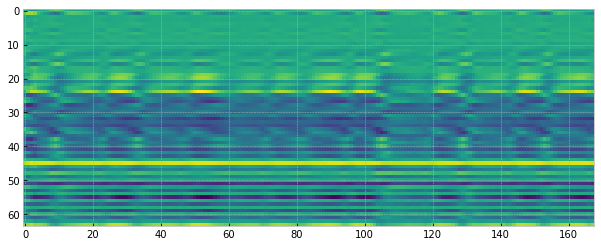

In [209]:
plt.imshow(model.conv_encoder(hist[[0]]).detach().numpy()[0])

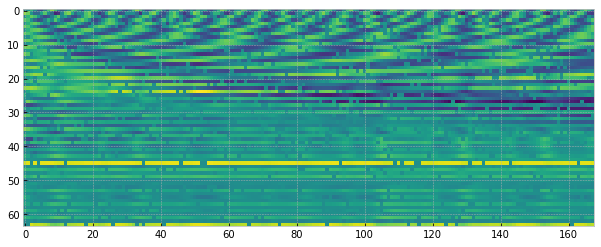

In [210]:
plt.imshow(model.pos_encoder(model.conv_encoder(hist[[0]])).detach().numpy()[0])

In [216]:
pos_enc = model.pos_encoder(model.conv_encoder(hist[[0]])).permute(2, 0, 1)
out, attn = model.transformer_block.self_attn(pos_enc, pos_enc, pos_enc, attn_mask=model.mask[:168, :168])

In [217]:
out.shape, attn.shape

(torch.Size([168, 1, 64]), torch.Size([1, 168, 168]))

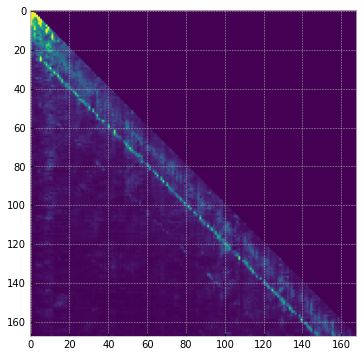

In [229]:
plt.figure(figsize=(6,6))
plt.imshow(np.log(1+attn[0].detach().numpy()), vmax=0.15)